In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sb
import missingno as msno
import numpy as np
import seaborn as sns

import requests
from bs4 import BeautifulSoup

import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from textblob import TextBlob

In [2]:
etihad_airways = pd.read_csv('raw_data/etihad_airways.csv')
qatar_airways = pd.read_csv('raw_data/qatar_airways.csv')
emirates = pd.read_csv('raw_data/emirates.csv')

In [3]:
etihad_airways['airline'] = 'etihad_airways'
qatar_airways['airline'] = 'qatar_airways'
emirates['airline'] = 'emirates'

merged_df = pd.concat([etihad_airways, qatar_airways, emirates], ignore_index=True)
merged_df.head(2)

,status,author,aircraft,review_date,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,wifi,value_for_money,recommended,overall,customer_review,airline
0,✅ Trip Verified,\nS Farham,NaN,1st January 2024,Family Leisure,Economy Class,Doha to Kolkata via Abu Dhabi,December 2023,3.0,5.0,3.0,3.0,1.0,NaN,3,no,5.0,I want to express my thanks to the wonderfu...,etihad_airways
1,✅ Trip Verified,\nVishal Dham,NaN,30th December 2023,Solo Leisure,Economy Class,Ahmedabad to Toronto via Abu Dhabi,December 2023,NaN,NaN,NaN,NaN,1.0,NaN,1,no,1.0,Very rude ground staff of Etihad Airways at ...,etihad_airways


In [4]:
# labels

def set_labels(df):
    df['label_recommended'] = df['recommended'].map({'yes': "positive", 'no': "negative"})
    df['label_overall'] = df['overall'].apply(lambda x: 'positive' if x > 6 else ('negative' if x < 4 else 'neutral'))
    
    return df

# preprocessing

def text_preprocessing(text):
    # Ensure that text is a Pandas Series
    if not isinstance(text, pd.Series):
        text = pd.Series(text)

    stop_words = set(stopwords.words('english'))

    result = text.str.lower()  # Lowercase text
    result = result.str.replace('\d+', '', regex=True)  # Remove numbers
    result = result.apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))  # Remove punctuations
    result = result.str.strip()  # Remove whitespace
    result = result.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  # Remove stopwords
    result = result.apply(lambda x: emoji.demojize(x))  # Remove emoji

    return result

df_labeled = set_labels(merged_df)
df_processed = df_labeled
df_processed['processed_review'] = df_processed.customer_review.apply(lambda x: text_preprocessing(x))
df_processed.head(2)

,status,author,aircraft,review_date,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,ground_service,wifi,value_for_money,recommended,overall,customer_review,airline,label_recommended,label_overall,processed_review
0,✅ Trip Verified,\nS Farham,NaN,1st January 2024,Family Leisure,Economy Class,Doha to Kolkata via Abu Dhabi,December 2023,3.0,5.0,...,1.0,NaN,3,no,5.0,I want to express my thanks to the wonderfu...,etihad_airways,negative,neutral,want express thanks wonderful crew abu dhabi k...
1,✅ Trip Verified,\nVishal Dham,NaN,30th December 2023,Solo Leisure,Economy Class,Ahmedabad to Toronto via Abu Dhabi,December 2023,NaN,NaN,...,1.0,NaN,1,no,1.0,Very rude ground staff of Etihad Airways at ...,etihad_airways,negative,negative,rude ground staff etihad airways ahmedabad air...


In [5]:
# lemmatization

import spacy

# Load the English language model in SpaCy
nlp = spacy.load('en_core_web_sm')

def text_lemmatize(text):
    doc = nlp(text)
    result = ' '.join([token.lemma_ for token in doc])
    
    return result

df_processed['lemmatized_review'] = df_processed.processed_review.apply(lambda x: text_lemmatize(x))
df_processed.head(2)

,status,author,aircraft,review_date,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,wifi,value_for_money,recommended,overall,customer_review,airline,label_recommended,label_overall,processed_review,lemmatized_review
0,✅ Trip Verified,\nS Farham,NaN,1st January 2024,Family Leisure,Economy Class,Doha to Kolkata via Abu Dhabi,December 2023,3.0,5.0,...,NaN,3,no,5.0,I want to express my thanks to the wonderfu...,etihad_airways,negative,neutral,want express thanks wonderful crew abu dhabi k...,want express thank wonderful crew abu dhabi ko...
1,✅ Trip Verified,\nVishal Dham,NaN,30th December 2023,Solo Leisure,Economy Class,Ahmedabad to Toronto via Abu Dhabi,December 2023,NaN,NaN,...,NaN,1,no,1.0,Very rude ground staff of Etihad Airways at ...,etihad_airways,negative,negative,rude ground staff etihad airways ahmedabad air...,rude ground staff etihad airways ahmedabad air...


In [6]:
# remove frequent words

frequent_words = ['etihad', 'airways', 'abu', 'dhabi', 'emirate', 'dubai', 'fly', 'flight', 'airline']
def remove_frequent_words(text):
    result = ' '.join([word for word in text.split() if word not in frequent_words])
    
    return result

df_processed['final_review'] = df_processed.lemmatized_review.apply(remove_frequent_words)
df_processed.head(2)

,status,author,aircraft,review_date,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,value_for_money,recommended,overall,customer_review,airline,label_recommended,label_overall,processed_review,lemmatized_review,final_review
0,✅ Trip Verified,\nS Farham,NaN,1st January 2024,Family Leisure,Economy Class,Doha to Kolkata via Abu Dhabi,December 2023,3.0,5.0,...,3,no,5.0,I want to express my thanks to the wonderfu...,etihad_airways,negative,neutral,want express thanks wonderful crew abu dhabi k...,want express thank wonderful crew abu dhabi ko...,want express thank wonderful crew kolkata espe...
1,✅ Trip Verified,\nVishal Dham,NaN,30th December 2023,Solo Leisure,Economy Class,Ahmedabad to Toronto via Abu Dhabi,December 2023,NaN,NaN,...,1,no,1.0,Very rude ground staff of Etihad Airways at ...,etihad_airways,negative,negative,rude ground staff etihad airways ahmedabad air...,rude ground staff etihad airways ahmedabad air...,rude ground staff ahmedabad airport inflight s...


### Sentiment analysis is employed to determine whether or not it performs well in product reviews.

#### BERT Architecture For Text Classification

#### VADER ((Valence Aware Dictionary and sEntiment Reasoner)

In [24]:
def vader_classification(df,airline):
    df_copy = df[df['airline'] == airline].copy()
    # Initialize the VADER sentiment analyzer
    nltk.download('vader_lexicon')

    analyzer = SentimentIntensityAnalyzer()

    # Add new columns for sentiment scores to the DataFrame
    df_copy['compound'] = df_copy['customer_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df_copy['vader_sentiment'] = df_copy['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')
    #df_copy['vader_sentiment'] = df_copy['compound'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))

    return df_copy

etihad_sentimens = vader_classification(df_processed,"etihad_airways")
etihad_sentimens.vader_sentiment.value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/blair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


vader_sentiment
negative    930
positive    814
neutral       3
Name: count, dtype: int64

In [17]:
from sklearn.metrics import accuracy_score

# Assuming 'positive' is represented as 1 and 'negative' as 0
y_test_binary = (etihad_sentimens['label_recommended'] == 'positive').astype(int)
y_pred_binary = (etihad_sentimens['vader_sentiment'] == 'positive').astype(int)

accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f'Vader Accuracy: {accuracy * 100:.2f}%')


Vader Accuracy: 78.36%


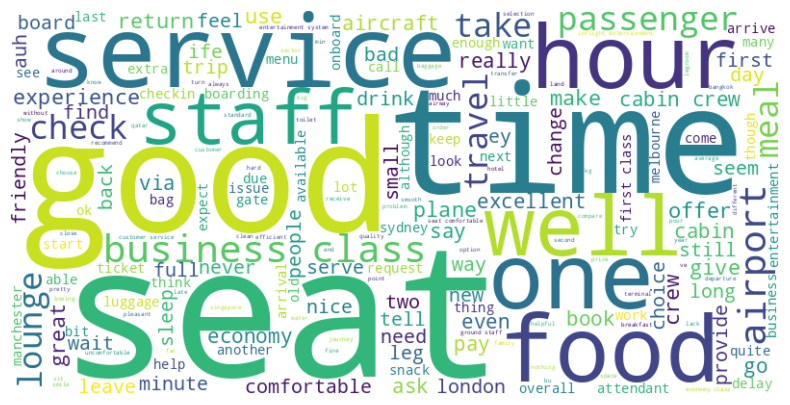

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract text from your DataFrame
text = ' '.join(etihad_sentimens[etihad_sentimens['vader_sentiment'] == 'positive']['final_review'].astype(str))

# Create a WordCloud object without specifying font_path
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

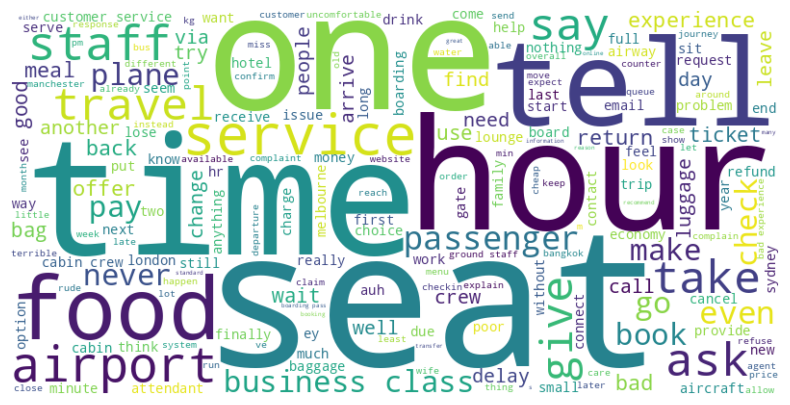

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract text from your DataFrame
text = ' '.join(etihad_sentimens[etihad_sentimens['vader_sentiment'] == 'negative']['final_review'].astype(str))

# Create a WordCloud object without specifying font_path
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()